# ***WARNING***: This document is obsolete.

## Please refer to the [LIGO-Virgo Public Alerts User Guide, https://emfollow.docs.ligo.org/userguide/](https://emfollow.docs.ligo.org/userguide/).

---

![LSC/Virgo Logo](http://www.ligo.org/images/logo02.gif)

# LIGO-Virgo EM Follow-Up Tutorial

by Leo P. Singer (NASA/GSFC) <leo.singer@ligo.org>

This document is LIGO-G1500442-v11.

## Abstract

This document explains how to receive, filter, and process gravitational-wave (GW) detection candidate alerts from Advanced LIGO and Virgo. We provide sample code in Python and document alternatives for users of other programming environments. You can download this document and run the code samples in [IPython Notebook](http://ipython.org/notebook.html).


## Table of Contents

[Introduction](#Introduction)

1. [Sign up for GCN/TAN network](#1.-Sign-up-for-GCN/TAN-network)
1. [Sign up for a GraceDb robot password](#2.-Sign-up-for-a-GraceDb-robot-password)
1. [Install some dependencies](#3.-Install-some-dependencies)
1. [Write GCN handler script](#4.-Write-GCN-handler-script)
1. [Working with probability sky maps](#5.-Working-with-probability-sky-maps)
1. [Basic observability calculations with Astropy](#6.-Basic-observability-calculations-with-Astropy)
1. [Submitting observation coordinates to GraceDB](#7.-Submitting-observation-coordinates-to-GraceDB)

[Appendix: Full example code](#Appendix:-Full-example-code)

## Introduction

The LIGO-Virgo data are analyzed in near real-time to search for GW transients due to compact binary coalescence (CBC) events or unmodeled "burst" sources. For each detection candidate, a series of alerts are produced and distributed via the [Gamma-ray Coordinates Network/Transient Astronomy Network (GCN/TAN)](http://gcn.gsfc.nasa.gov).

<img src="http://gcn.gsfc.nasa.gov/GCN.gif" alt="GCN/TAN Network" width="378" height="289">

The GCN/TAN system may already be familiar to some, as it is has been in use since the early 1990s to transmit times and coordinates of gamma-ray bursts (GRBs) detected by gamma-ray space missions to ground-based observers. However, there are three peculiariaties of GW observations that veteran GCN users should be aware of:

1. Unlike GRBs, GW sources cannot (always) be localized to a unique sky location; GW position reconstructions are (sometimes) multimodal and non-Gaussian. As a consequence, LIGO-Virgo GCN notices do *not* contain a RA, Dec, or error radius; instead they contain a pointer URL to a FITS file containing a probability sky map in the [HEALPix](http://healpix.sourceforge.net) all-sky projection.
1. GCN notices will produce LIGO-Virgo candidates that span a range of significances. The significance of a candidate is reported as the false alarm rate (FAR). The FAR of a detection candidate measures approximately how frequently an event of similar strenght occurs due to chance noise fluctuations or instrumental glitches. A FAR of 1/century ($\sim 3 \times 10^{-10}$ Hz) is generally regarded as sufficient for a "confident" detection. However, alerts will produced for all events with FAR≥1/month ($\sim 4\times10^{-7}$ Hz), such that there should be at least one alert per month on average.
1. The first few GW alerts will be distributed privately to LIGO MOU partners, over a purpose-built GCN connection.

## 1. Sign up for GCN/TAN network

The first step is to sign up for the GCN network. Signing up for LIGO/Virgo GCN notices is slightly different from the [standard signup process](http://gcn.gsfc.nasa.gov/invitation.html). However, if you are already receiving GCN notices (for example, for GRB follow-up), then you can reuse your existing GCN configuration and add the LIGO/Virgo notices.

There are [several distribution methods for GCN notices](http://gcn.gsfc.nasa.gov/gcn_describe.html#tc7). For the purpose of this tutorial, we will focus on VOEvent over VOEvent Transport Protocol, which is among the more convenient methods for autonomous operations. However, you can use any other distribution method of your choice.

To receive VOEvents, you will need a computer with a static IP address and you will need to register the IP address from which you will connect to the GCN network. Do the following two steps to submit a new GCN site configuration:

1. Go to http://gcn.gsfc.nasa.gov/lvc_config_builder.html, fill out the form, and then click the "Send LVC Notice request to GCN Admin" button.
2. If you are registering as a new GCN recipient (as opposed to adding LIGO/Virgo notices to an existing site configuration), then click the ["New Site or New User"](http://gcn.gsfc.nasa.gov/cfg.html?) button and fill out the resulting form. Select the `VOEVENT2.0` option for the `Distribution Method` field.

## 2. Sign up for a GraceDb robot password

You will need a *robot password* to download files that are linked from the GCN notices. This is an automatically generated password that you can use to download files from GraceDb in a script. It is different from your log in for the GraceDb web site, but you use the GraceDb web site to manage your robot password. Here is how to obtain a robot password.

1. Got to https://gracedb.ligo.org/ and log in.
1. Click the **Options** tab (see screenshot below).
![GraceDb screenshot 1](gracedb-screenshot-1.png)
1. Click the **Manage Password** link (see screenshot below).
![GraceDb screenshot 1](gracedb-screenshot-2.png)
1. Click **Get me a password!** (See screenshot below.) ***Warning: if you had an old robot password, this will reset it and generate a new one.***
![GraceDb screenshot 1](gracedb-screenshot-3.png)
1. Record the robot user name (which is the same as your user name for the GraceDb web site) and the generated robot password (see screenshot below).
![GraceDb screenshot 1](gracedb-screenshot-4.png)
1. **Optional, but recommended:** For convenience, we suggset that you add the following line to your [~/.netrc](https://www.gnu.org/software/inetutils/manual/html_node/The-_002enetrc-file.html) file:

  `machine gracedb.ligo.org login` *albert.einstein@LIGO.ORG* `password` *ABCDEabcde0123456789*

replacing *albert.einstein@LIGO.ORG* with the robot user name and *ABCDEabcde0123456789* with the robot password. This will make it so that you can call [`curl`](http://linux.die.net/man/1/curl) or other HTTP downloader programs without explicitly providing the user name and password. To test your user name and password, you can run the following command:

    curl --netrc https://gracedb.ligo.org/apibasic/

## 3. Install some dependencies

You will need to install a few third-party Python packages to run the example code in this tutorial. These include:

* [pygcn](https://pypi.python.org/pypi/pygcn) for connecting to GCN (alternatives: [comet](https://pypi.python.org/pypi/Comet))
* [requests](https://pypi.python.org/pypi/requests) for easy HTTP downloads in Python (many [alternatives](https://docs.python.org/2/library/urllib.html) in Python standard library)
* [healpy](https://pypi.python.org/pypi/healpy), for decoding HEALPix images (alternatives: [DS9](http://ds9.si.edu), [Aladin](http://aladin.u-strasbg.fr), [HEALPix bindings for C/C++/Fortran/Java/IDL](http://healpix.sourceforge.net), [reprojection with the Python reproject package](http://reproject.readthedocs.org/en/latest/healpix.html))
* [astropy](https://pypi.python.org/pypi/astropy) version 1.0.1 or newer (optional, for computing observability windows, etc.)
* [numpy](http://www.numpy.org) and [matplotlib](http://matplotlib.org), popular math and plotting packages for Python

If you are on a Mac and use the [MacPorts](http://macports.org) package manager, you can install all of the above with the following command:

    $ sudo port install py27-gcn py27-lxml py27-requests py27-healpy py27-astropy

Otherwise, the fastest way to install the dependencies is with [`pip`](https://pip.pypa.io/en/latest/quickstart.html), a package manager that comes with most Python distributions. To install these packages with `pip`, run the following command:

    $ pip install pygcn lxml requests healpy astropy

## 4. Write GCN handler script

Now we'll write a GCN handler script. First, some imports...

In [1]:
# Python standard library imports
import tempfile
import shutil
import sys
import glob

# Third-party imports
import gcn
import gcn.handlers
import gcn.notice_types
import requests
import healpy as hp
import numpy as np

*IPython Notebook **only***: If you are following along and running commands in the IPython Notebook, you should also run the following command so that plots are [rendered inline inside the notebook](http://ipython.org/ipython-doc/stable/interactive/magics.html?highlight=matplotlib%20inline#magic-matplotlib):

In [2]:
%matplotlib inline

Next, we'll write a function that we want to get called every time a GCN notice is received. We will use the `@gcn.handlers.include_notice_types` [function decorator](https://docs.python.org/3/glossary.html#term-decorator) to specify that we only want to process certain notice types. There are three notice types:

1. `LVC_PRELIMINARY`: Provides the time, significance, and basic parameters about a GW detection candidate. No localization information. Sent with a latency of a minute or so.
1. `LVC_INITIAL`: A rapid sky localization is available. Sent with a latency of a few minutes.
1. `LVC_UDPATE`: A refined sky localization is availaable. Sent with a latency of hours or more.

In the following example, we will process only the last two types (`LVC_INITIAL` and `LVC_UPDATE`), which contain links to sky map FITS files. The following handler function will parse out the URL of the FITS file, download it, and extract the probability sky map.

Events come in two very general flavors: 'CBC' or compact binary coalescence candidates detected by matched filtering, and generic 'Burst' candidates detected by model-independent methods. Most users will want to receive only 'CBC' or only 'Burst' events. In this example code, we are going to keep only 'CBC' events.

***Very important:*** Note that mock or 'test' observations are denoted by the `role="test"` VOEvent attribute. Alerts resulting from real LIGO/Virgo science data will always have `role="observation"`. The sample code below will respond **only** to 'test' events. When preparing for actual observations, you **must remember to switch to 'observation' events**.

In [ ]:
def get_skymap(root):
    """
    Look up URL of sky map in VOEvent XML document,
    download sky map, and parse FITS file.
    """
    # Read out URL of sky map.
    # This will be something like
    # https://gracedb.ligo.org/apibasic/events/M131141/files/bayestar.fits.gz
    skymap_url = root.find(
        "./What/Param[@name='SKYMAP_URL_FITS_BASIC']").attrib['value']

    # Send HTTP request for sky map
    response = requests.get(skymap_url, stream=True)

    # Uncomment to save VOEvent payload to file
    # open('example.xml', 'w').write(payload)

    # Raise an exception unless the download succeeded (HTTP 200 OK)
    response.raise_for_status()

    # Create a temporary file to store the downloaded FITS file
    with tempfile.NamedTemporaryFile() as tmpfile:
        # Save the FITS file to the temporary file
        shutil.copyfileobj(response.raw, tmpfile)
        tmpfile.flush()

        # Uncomment to save FITS payload to file
        # shutil.copyfileobj(reponse.raw, open('example.fits.gz', 'wb'))

        # Read HEALPix data from the temporary file
        skymap, header = hp.read_map(tmpfile.name, h=True, verbose=False)
        header = dict(header)

    # Done!
    return skymap, header


# Function to call every time a GCN is received.
# Run only for notices of type LVC_INITIAL or LVC_UPDATE.
@gcn.handlers.include_notice_types(
    gcn.notice_types.LVC_INITIAL,
    gcn.notice_types.LVC_UPDATE)
def process_gcn(payload, root):
    # Print the alert
    print('Got VOEvent:')
    print(payload)

    # Respond only to 'test' events.
    # VERY IMPORTANT! Replce with the following line of code
    # to respond to only real 'observation' events.
    # if root.attrib['role'] != 'observation': return
    if root.attrib['role'] != 'test': return

    # Respond only to 'CBC' events. Change 'CBC' to "Burst' to respond to only
    # unmodeled burst events.
    if root.find("./What/Param[@name='Group']").attrib['value'] != 'CBC': return

    # Read out integer notice type (note: not doing anythin with this right now)
    notice_type = int(root.find("./What/Param[@name='Packet_Type']").attrib['value'])

    # Read sky map
    skymap, header = get_skymap(root)

Finally, we will listen for GCNs. You need to tell the `gcn.listen` function on what port you want to connect to the GCN network; this will be port 8096. You also need to tell `gcn.listen` which function to call whenever it receives an GCN; this will be the `process_gcn` function that we just defined.

When you run the following code snippet, the `gcn.listen` function will continue until you interrupt the program (by pressing the stop button in IPython Notebook, typing Control-C in the terminal, or sending a kill signal to your Python script).

Note: `gcn.listen` will automatically reconnect to the GCN network if the network connection is broken.

In [ ]:
# Listen for GCNs until the program is interrupted
# (killed or interrupted with control-C).
gcn.listen(port=8096, handler=process_gcn)

That was fun! Now kill the listener: if you are running the example code in an IPython Notebook, press the stop button. If you copied the example code into a standalone Python script, then kill the script by typing control-C.

## 5. Working with probability sky maps

Let's take a look at what is inside one of the LIGO/Virgo probability sky maps. They are FITS image files and can be manipulated and viewed with many commonplace FITS tools. However, they are a little unusual in two regards. First, since they are all-sky images, they are stored in the [HEALPix](http://healpix.sourceforge.net) projection, a format that is used for [Planck](http://www.cosmos.esa.int/web/planck) all-sky CMB maps and by Aladin for [archival all-sky survey images](http://aladin.u-strasbg.fr/java/nph-aladin-new.pl?frame=aladinHpxList). Second, the value stored at each pixel is the probability that the gravitational-wave source is within that pixel.

![HEALPix projection](http://healpix.jpl.nasa.gov/images/healpixGridRefinement.jpg)

Let's download one of them with `curl`:

    $ curl --netrc -O https://gracedb.ligo.org/apibasic/events/T125706/files/bayestar.fits.gz

or with `wget`:

    $ wget --auth-no-challenge https://gracedb.ligo.org/apibasic/events/T125706/files/bayestar.fits.gz

We can look at the metadata inside the FITS file by printing its header with tools like
[funhead](http://linux.die.net/man/1/funhead) from [Funtools](https://github.com/ericmandel/funtools), [imhead](http://linux.die.net/man/1/imhead) from [WCSTools](http://tdc-www.harvard.edu/wcstools/), or [fitsheader](http://astropy.readthedocs.org/en/latest/io/fits/usage/scripts.html?highlight=fitsheader#module-astropy.io.fits.scripts.fitsheader) from [Astropy](http://www.astropy.org):

    $ funhead -a bayestar.fits.gz
    SIMPLE  =                    T / conforms to FITS standard                      
    BITPIX  =                    8 / array data type                                
    NAXIS   =                    0 / number of array dimensions                     
    EXTEND  =                    T                                                  
    END                                                                             
    		Extension: XTENSION

    XTENSION= 'BINTABLE'           / binary table extension                         
    BITPIX  =                    8 / array data type                                
    NAXIS   =                    2 / number of array dimensions                     
    NAXIS1  =                 4096 / length of dimension 1                          
    NAXIS2  =                 3072 / length of dimension 2                          
    PCOUNT  =                    0 / number of group parameters                     
    GCOUNT  =                    1 / number of groups                               
    TFIELDS =                    1 / number of table fields                         
    TTYPE1  = 'PROB    '                                                            
    TFORM1  = '1024E   '                                                            
    TUNIT1  = 'pix-1   '                                                            
    PIXTYPE = 'HEALPIX '           / HEALPIX pixelisation                           
    ORDERING= 'NESTED  '           / Pixel ordering scheme, either RING or NESTED   
    COORDSYS= 'C       '           / Ecliptic, Galactic or Celestial (equatorial)   
    EXTNAME = 'XTENSION'           / name of this binary table extension            
    NSIDE   =                  512 / Resolution parameter of HEALPIX                
    FIRSTPIX=                    0 / First pixel # (0 based)                        
    LASTPIX =              3145727 / Last pixel # (0 based)                         
    INDXSCHM= 'IMPLICIT'           / Indexing: IMPLICIT or EXPLICIT                 
    OBJECT  = 'T125706 '           / Unique identifier for this event               
    REFERENC= 'https://gracedb.ligo.org/events/T125706' / URL of this event         
    INSTRUME= 'H1,L1   '           / Instruments that triggered this event          
    DATE-OBS= '2010-08-30T10:11:34.322149' / UTC date of the observation            
    MJD-OBS =     55438.4247028027 / modified Julian date of the observation        
    DATE    = '2014-08-13T19:21:12' / UTC date of file creation                     
    CREATOR = 'bayestar_localize_lvalert' / Program that created this file          
    ORIGIN  = 'LIGO/Virgo'         / Organization responsible for this FITS file    
    COMMENT                                                                         
    COMMENT This simulated detection candidate is a copy of event 11178             
    COMMENT from the 2015 scenario of the "First Two Years" paper                   
    COMMENT (http://www.ligo.org/scientists/first2years/).                          
    END                                                                             

There are several useful pieces of information here:

* `COORDSYS=C`, telling you that the HEALPix projection is in the Celestial (equatorial) frame (as all LIGO/Virgo probability sky maps will be).
* `OBJECT`, the unique LIGO/Virgo identifier for the event.
* `REFERENC`, a link to the candidate page in the [GraceDb](https://gracedb.ligo.org) gravitational-wave candidate event database.
* `INSTRUME`, a list of gravitational-wave sites that triggered on the event (`H1` represents LIGO Hanford, `L1` is LIGO Livingston, and `V1` is Virgo).
* `DATE-OBS`, the UTC time of the event. In the case of a compact binary coalescence candidate, this is the time that the signal from the merger passed through the geocenter.
* `MJD-OBS`, same as `DATE-OBS`, but given as a modified Julian day.

You can view the sky map in many common FITS image viewers such as [Aladin](http://aladin.u-strasbg.fr):

![Aladin screenshot](aladin-screenshot.png)

or [DS9](http://ds9.si.edu/doc/ref/file.html#FITSHEALPIXTable) (although DS9 shows HEALPix sky maps in an unusual orientation; see [Figure 4](http://mnras.oxfordjournals.org/content/381/2/865/F4.expansion.html) of [Calabretta & Roukema 2007](http://adsabs.harvard.edu/abs/2007MNRAS.381..865C) for information):

![DS9 screenshot](ds9-screenshot.png)

Now, let's go through some examples of manipulating HEALPix sky maps programmatically. The [HEALPix project](http://healpix.sourceforge.net) provides official libraries for many languages, including [C, C++, Fortran, IDL, Java, and Python](http://healpix.sourceforge.net/documentation.php). However, since this is a Python tutorial, we are going to demonstrate how to manipulate HEALPix maps with the official Python library, [Healpy](http://healpy.readthedocs.org/).

First, if you have not already downloaded an example sky map, you can do so now by having Python call `curl` on the command line:

In [3]:
# Download sky map
import subprocess
subprocess.check_call([
    'curl', '-O', '--netrc',
    'https://gracedb.ligo.org/apibasic/events/T125706/files/bayestar.fits.gz'])

0

Next, we need to read in the file with Healpy:

In [4]:
hpx = hp.read_map('bayestar.fits.gz')

NSIDE = 512
ORDERING = NESTED in fits file
Ordering converted to RING


You can suppress printing informational messages while loading the file by passing the keyword argument `verbose=False`. You can read both the HEALPix image data and the FITS header by passing the `h=True` keyword argument:

In [5]:
hpx, header = hp.read_map('bayestar.fits.gz', h=True, verbose=False)

The image data is a 1D array of values:

In [6]:
hpx

array([  3.08905283e-22,   3.04303258e-22,   1.21389563e-22, ...,
         9.39631031e-22,   3.19591130e-22,   2.66302276e-22])

Healpy has [several useful plotting routines](http://healpy.readthedocs.org/en/latest/healpy_visu.html) including `mollview` for plotting a Mollweide-projection all-sky map:

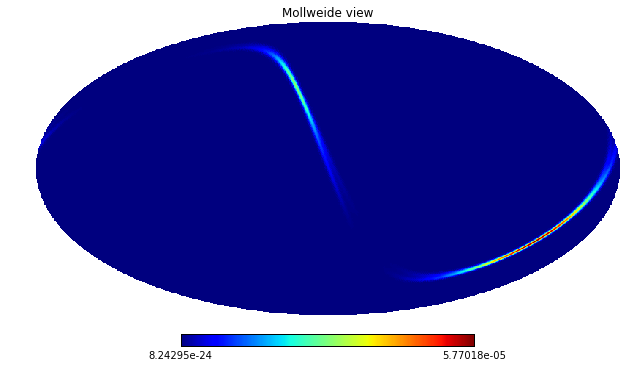

In [7]:
hp.mollview(hpx)

Each entry in the array represents the probability contained within a quadrilateral pixel whose position on the sky is uniquely specified by the index in the array and the array's length. Because HEALPix pixels are equal area, we can find the number of pixels per square degree just from the length of the HEALPix array:

In [8]:
npix = len(hpx)
sky_area = 4 * 180**2 / np.pi
sky_area / npix

0.013113963206424481

The [`pix2ang`](http://healpy.readthedocs.org/en/latest/generated/healpy.pixelfunc.pix2ang.html) function converts from pixel index to spherical polar coordinates; the function [`ang2pix`](http://healpy.readthedocs.org/en/latest/generated/healpy.pixelfunc.ang2pix.html) does the reverse.

Both `pix2ang` and `ang2pix` take, as their first argument, `nside`, the lateral resolution fo the HEALPix map. You can find `nside` from the length of the image array by calling [`npix2nside`](http://healpy.readthedocs.org/en/latest/generated/healpy.pixelfunc.npix2nside.html#healpy.pixelfunc.npix2nside):

In [9]:
nside = hp.npix2nside(npix)
nside

512

Let's look up the right ascension and declination of pixel number 123. We'll call `pix2ang` to get the spherical polar coordinates $(\theta, \phi)$ in radians, and then use Numpy's [`rad2deg`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.rad2deg.html) function to convert these to right ascension and declination in degrees.

In [10]:
ipix = 123
theta, phi = hp.pix2ang(nside, ipix)
ra = np.rad2deg(phi)
dec = np.rad2deg(0.5 * np.pi - theta)
ra, dec

(129.375, 89.269029291573901)

Let's find which pixel contains the point RA=194.95, Dec=27.98.

In [11]:
ra = 194.95
dec = 27.98
theta = 0.5 * np.pi - np.deg2rad(dec)
phi = np.deg2rad(ra)
ipix = hp.ang2pix(nside, theta, phi)
ipix

833621

Let's find the highest probability pixel. What is the probability inside it?

In [12]:
ipix_max = np.argmax(hpx)
hpx[ipix_max]

5.7702549383975565e-05

Where is the highest probability pixel on the sky? Use `pix2ang`.

In [13]:
theta, phi = hp.pix2ang(nside, ipix_max)
ra = np.rad2deg(phi)
dec = np.rad2deg(0.5 * np.pi - theta)
ra, dec

(213.22265625, -37.450292350169015)

How do we find the probability that the source is contained within a circle on the sky? First we find the pixels that are contained within the circle using `query_disc`. Note that `query_disc` takes as its arguments the Cartesian coordinates of the center of the circle, and its radius in radians.

Then, we sum the values of the HEALPix image array contained at those pixels.

In [14]:
# RA, Dec, and radius of circle in degrees
ra = 213.22
dec = -37.45
radius = 3.1

# Spherical polar coordinates and radius of circle in radians
theta = 0.5 * np.pi - np.deg2rad(dec)
phi = np.deg2rad(ra)
radius = np.deg2rad(radius)

# Cartesian coordinates of center of circle
xyz = hp.ang2vec(theta, phi)

# Array of indices of pixels inside circle
ipix_disc = hp.query_disc(nside, xyz, radius)

# Probability that source is within circle
hpx[ipix_disc].sum()

0.056844148994230181

Similarly, we can use the `query_polygon` function to look up the indices of the pixels within a polygon (defined by the Cartesian coordinates of its vertices), and then compute the probability that the source is inside that polygon by summing the values of the pixels.

In [15]:
# Vertices of polygon
xyz = [[-0.69601758, -0.41315628, -0.58724902],
       [-0.68590811, -0.40679797, -0.60336181],
       [-0.69106913, -0.39820114, -0.60320752],
       [-0.7011786 , -0.40455945, -0.58709473]]

# Array of indices of pixels inside polygon
ipix_poly = hp.query_polygon(nside, xyz)

# Probability that source is within polygon
hpx[ipix_poly].sum()

0.0011913816551896161

These are all of the HEALPix functions from Healpy that we will need for the remainder of the this tutorial.

Other useful Healpy functions include [`ud_grade`](http://healpy.readthedocs.org/en/latest/generated/healpy.pixelfunc.ud_grade.html) for upsampling or downsampling a sky map, and [`get_interp_val`](http://healpy.readthedocs.org/en/latest/generated/healpy.pixelfunc.get_interp_val.html#healpy.pixelfunc.get_interp_val) for performing bilinear interpolation between pixels. See the [Healpy tutorial](http://healpy.readthedocs.org/en/latest/tutorial.html) for other useful operations.

## 6. Basic observability calculations with Astropy

Now we are going to teach our GCN handler how to determine whether a gravitational-wave event is observable. We are goint to use the [astropy.coordinates](http://astropy.readthedocs.org/en/stable/coordinates/index.html) module of the [Astropy package](http://astropy.org) to do [observation planning in Python](http://astropy.readthedocs.org/en/stable/coordinates/observing-example.html). First, we will need to import a few extra Python modules:

In [ ]:
import astropy.coordinates
import astropy.time
import astropy.units as u

The LIGO/Virgo probability sky maps are always in equatorial coordinates. Once we have looked up the coordinates of the HEALPix pixels, we will use [the positional astronomy features of Astropy](http://astropy.readthedocs.org/en/stable/coordinates/observing-example.html) to transform those coordinates to an alt/az frame for a particular site on the Earth at a particular time. Then we can quickly determine which pixels are visible from that site at that time, and integrate (sum) the probability contained in those pixels.

Note: users may want to do something more sophisticated like determine how much of the probability is visible for at least a certain length of time. This example will illustrate one key function of HEALPix (looking up coordinates of the grid with `hp.pix2ang`) and some of the key positional astronomy functions with Astropy.

In [ ]:
def prob_observable(m, header):
    """
    Determine the integrated probability contained in a gravitational-wave
    sky map that is observable from a particular ground-based site at a
    particular time.

    Bonus: make a plot of probability versus UTC time!
    """

    # Determine resolution of sky map
    npix = len(m)
    nside = hp.npix2nside(npix)

    # Get time now
    time = astropy.time.Time.now()
    # Or at the time of the gravitational-wave event...
    # time = astropy.time.Time(header['MJD-OBS'], format='mjd')
    # Or at a particular time...
    # time = astropy.time.Time('2015-03-01 13:55:27')

    # Geodetic coordinates of observatory (example here: Mount Wilson)
    observatory = astropy.coordinates.EarthLocation(
        lat=34.2247*u.deg, lon=-118.0572*u.deg, height=1742*u.m)

    # Alt/az reference frame at observatory, now
    frame = astropy.coordinates.AltAz(obstime=time, location=observatory)

    # Look up (celestial) spherical polar coordinates of HEALPix grid.
    theta, phi = hp.pix2ang(nside, np.arange(npix))
    # Convert to RA, Dec.
    radecs = astropy.coordinates.SkyCoord(
        ra=phi*u.rad, dec=(0.5*np.pi - theta)*u.rad)

    # Transform grid to alt/az coordinates at observatory, now
    altaz = radecs.transform_to(frame)

    # Where is the sun, now?
    sun_altaz = astropy.coordinates.get_sun(time).transform_to(altaz)

    # How likely is it that the (true, unknown) location of the source
    # is within the area that is visible, now? Demand that sun is at
    # least 18 degrees below the horizon and that the airmass
    # (secant of zenith angle approximation) is at most 2.5.
    prob = m[(sun_altaz.alt <= -18*u.deg) & (altaz.secz <= 2.5)].sum()

    # Done!
    return prob

Finally, we need to update our GCN handler to call this function.

In [ ]:
# Function to call every time a GCN is received.
# Run only for notices of type LVC_INITIAL or LVC_UPDATE.
@gcn.handlers.include_notice_types(
    gcn.notice_types.LVC_INITIAL,
    gcn.notice_types.LVC_UPDATE)
def process_gcn(payload, root):
    # Print the alert
    print('Got VOEvent:')
    print(payload)

    # Respond only to 'test' events.
    # VERY IMPORTANT! Replce with the following line of code
    # to respond to only real 'observation' events.
    # if root.attrib['role'] != 'observation': return
    if root.attrib['role'] != 'test': return

    # Respond only to 'CBC' events. Change 'CBC' to "Burst' to respond to only
    # unmodeled burst events.
    if root.find("./What/Param[@name='Group']").attrib['value'] != 'CBC': return

    skymap, header = get_skymap(root)
    prob = prob_observable(skymap, header)
    print('Source has a %d%% chance of being observable now' % round(100 * prob))
    if prob > 0.5:
        pass # FIXME: perform some action

Let's run the new GCN handler now...

In [ ]:
# Listen for GCNs until the program is interrupted
# (killed or interrupted with control-C).
gcn.listen(port=8096, handler=process_gcn)

## 7. Submitting observation coordinates to GraceDB

Suppose you have performed some EM observations to follow up on a candidate GW event, and you now want to supply the coordinates of those observations to the LV-EM group.  The first step is to obtain a robotic access password from GraceDB and add it to a netrc file (see Section 2). One can then use the Python GraceDB client in order to submit a list of coordinates to GraceDB. To install the GraceDB client package:

    $ pip install ligo-gracedb 

Note: It is highly recommended to install the GraceDB client (as well as other packages described used in this tutorial) inside a [virtual environment](https://virtualenv.pypa.io/en/latest/). This isolates the packages required for interacting with GraceDB from other packages on the system.
Now that the GraceDB client is installed, one can use a script such as this to submit observation records to GraceDB:


In [ ]:
from ligo.gracedb.rest import GraceDbBasic, HTTPError

service = 'https://gracedb.ligo.org/apibasic/'
g = GraceDbBasic(service)

graceid = 'T125706'
raList = [45.0, 47.0, 49.0]
raWidthList = 2.0
decList = [45.0, 47.0, 49.0]
decWidthList = 2.0
startTimeList = ['2015-05-01T12:30:10.95', '2015-05-01T12:31:10.95', '2015-05-01T12:32:10.95']
durationList = 100.0
comment = 'Some text comment goes here. This is optional.'

g.writeEMObservation(graceid, 'Test', raList, raWidthList,
    decList, decWidthList, startTimeList, durationList, comment)

In the above example, the lists of ra and dec values were chosen arbitrarily, as well as the start times and durations (or exposure times). Since the comma-separated lists have three elements, there will be three footprints associated with this observation. And since only one value was provided for the raWidth and decWidth, these widths will be assumed to apply to all three footprints.

It is possible to create the same record using curl instead:

    $ curl -X POST --netrc --data "group=Test&raList=45,47,49&raWidthList=2&decList=45,47,49&decWidthList=2&startTimeList=2015-05-01T12:30:10.95,2015-05-01T12:31:10.95,2015-05-01T12:32:10.95&durationList=100,100,100" https://gracedb.ligo.org/apibasic/events/T125706/emobservation/ 

However, the data argument in the above curl command is rather unwieldy--and this is only with three simple footprints. So using Python (as in the above code example) or your own favorite language and HTTP library is much preferred. We are also planning an email submission mechanism which may be eaiser for some users. 


# Appendix: Full example code

Here is a complete, working GCN processing script. Copy it into a `.py` file and customize as needed.

In [ ]:
# Python standard library imports
import tempfile
import shutil
import sys
import glob


# Third-party imports
import gcn
import gcn.handlers
import gcn.notice_types
import requests
import healpy as hp
import numpy as np
import astropy.coordinates
import astropy.time
import astropy.units as u


def get_skymap(root):
    """
    Look up URL of sky map in VOEvent XML document,
    download sky map, and parse FITS file.
    """
    # Read out URL of sky map.
    # This will be something like
    # https://gracedb.ligo.org/apibasic/events/M131141/files/bayestar.fits.gz
    skymap_url = root.find(
        "./What/Param[@name='SKYMAP_URL_FITS_BASIC']").attrib['value']

    # Send HTTP request for sky map
    response = requests.get(skymap_url, stream=True)

    # Uncomment to save VOEvent payload to file
    # open('example.xml', 'w').write(payload)

    # Raise an exception unless the download succeeded (HTTP 200 OK)
    response.raise_for_status()

    # Create a temporary file to store the downloaded FITS file
    with tempfile.NamedTemporaryFile() as tmpfile:
        # Save the FITS file to the temporary file
        shutil.copyfileobj(response.raw, tmpfile)
        tmpfile.flush()

        # Uncomment to save FITS payload to file
        # shutil.copyfileobj(reponse.raw, open('example.fits.gz', 'wb'))

        # Read HEALPix data from the temporary file
        skymap, header = hp.read_map(tmpfile.name, h=True, verbose=False)
        header = dict(header)

    # Done!
    return skymap, header


def prob_observable(m, header):
    """
    Determine the integrated probability contained in a gravitational-wave
    sky map that is observable from a particular ground-based site at a
    particular time.

    Bonus: make a plot of probability versus UTC time!
    """

    # Determine resolution of sky map
    npix = len(m)
    nside = hp.npix2nside(npix)

    # Get time now
    time = astropy.time.Time.now()
    # Or at the time of the gravitational-wave event...
    # time = astropy.time.Time(header['MJD-OBS'], format='mjd')
    # Or at a particular time...
    # time = astropy.time.Time('2015-03-01 13:55:27')

    # Geodetic coordinates of observatory (example here: Mount Wilson)
    observatory = astropy.coordinates.EarthLocation(
        lat=34.2247*u.deg, lon=-118.0572*u.deg, height=1742*u.m)

    # Alt/az reference frame at observatory, now
    frame = astropy.coordinates.AltAz(obstime=time, location=observatory)

    # Look up (celestial) spherical polar coordinates of HEALPix grid.
    theta, phi = hp.pix2ang(nside, np.arange(npix))
    # Convert to RA, Dec.
    radecs = astropy.coordinates.SkyCoord(
        ra=phi*u.rad, dec=(0.5*np.pi - theta)*u.rad)

    # Transform grid to alt/az coordinates at observatory, now
    altaz = radecs.transform_to(frame)

    # Where is the sun, now?
    sun_altaz = astropy.coordinates.get_sun(time).transform_to(altaz)

    # How likely is it that the (true, unknown) location of the source
    # is within the area that is visible, now? Demand that sun is at
    # least 18 degrees below the horizon and that the airmass
    # (secant of zenith angle approximation) is at most 2.5.
    prob = m[(sun_altaz.alt <= -18*u.deg) & (altaz.secz <= 2.5)].sum()

    # Done!
    return prob


# Function to call every time a GCN is received.
# Run only for notices of type LVC_INITIAL or LVC_UPDATE.
@gcn.handlers.include_notice_types(
    gcn.notice_types.LVC_INITIAL,
    gcn.notice_types.LVC_UPDATE)
def process_gcn(payload, root):
    # Print the alert
    print('Got VOEvent:')
    print(payload)

    # Respond only to 'test' events.
    # VERY IMPORTANT! Replce with the following line of code
    # to respond to only real 'observation' events.
    # if root.attrib['role'] != 'observation': return
    if root.attrib['role'] != 'test': return

    # Respond only to 'CBC' events. Change 'CBC' to "Burst' to respond to only
    # unmodeled burst events.
    if root.find("./What/Param[@name='Group']").attrib['value'] != 'CBC': return

    skymap, header = get_skymap(root)
    prob = prob_observable(skymap, header)
    print('Source has a %d%% chance of being observable now' % round(100 * prob))
    if prob > 0.5:
        pass # FIXME: perform some action


# Listen for GCNs until the program is interrupted
# (killed or interrupted with control-C).
gcn.listen(port=8096, handler=process_gcn)